In [7]:
import sys
from sklearn.ensemble.forest import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection._search import GridSearchCV
from sklearn.model_selection._split import StratifiedKFold
from sklearn import svm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_data = [train, test]

print('train.describe')
print(train.describe())

print('\ntrain_info')
print(train.info())

print('\ntest_info')
print(test.info())

survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]

print ("\n\nSurvived: %i (%.1f%%)" % (len(survived), float(len(survived))/len(train)*100.0))
print ("Not Survived: %i (%.1f%%)" % (len(not_survived), float(len(not_survived))/len(train)*100.0))
print ("Total: %i" % len(train))

train.describe
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

train_info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 

----------------------------------------
Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64


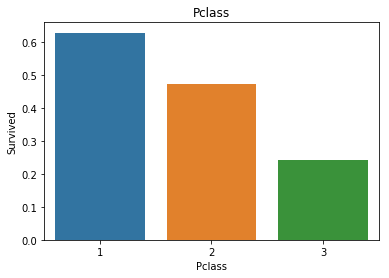

----------------------------------------
Sex  Survived
0    1           233
     0            81
1    0           468
     1           109
Name: Survived, dtype: int64


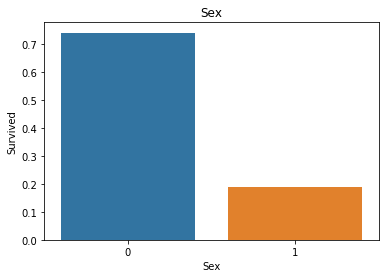

----------------------------------------
Embarked  Survived
0         0           427
          1           219
1         1            93
          0            75
2         0            47
          1            30
Name: Survived, dtype: int64


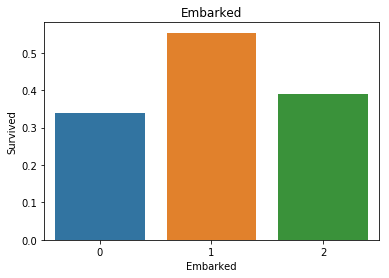

Sex       0    1
Pclass          
1        94  122
2        76  108
3       144  347


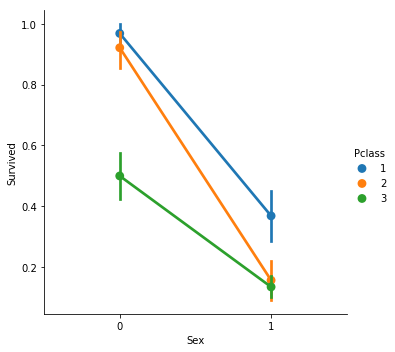

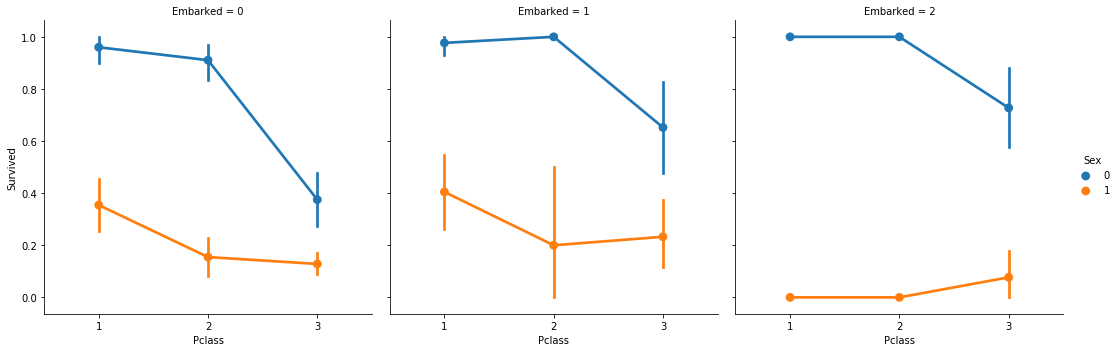

In [28]:
# --- plots    
def barplot(x_axis):
    print('-'*40)
    print(train.groupby(x_axis).Survived.value_counts())
    sns.barplot(x=x_axis, y='Survived', ci=None, data=train)
    plt.title(x_axis)
    plt.show()
 
 
barplot('Pclass')
barplot('Sex')
barplot('SibSp')
barplot('Parch')
barplot('Embarked')
  
  
tab = pd.crosstab(train['Pclass'], train['Sex'])
print (tab)
  
  
sns.factorplot('Sex', 'Survived', hue='Pclass', data=train)
plt.show()
  
sns.factorplot(x='Pclass', y='Survived', hue='Sex', col='Embarked', data=train)
plt.show()



In [29]:

total_survived = train[train['Survived']==1]
total_not_survived = train[train['Survived']==0]
male_survived = train[(train['Survived']==1) & (train['Sex']=="male")]
female_survived = train[(train['Survived']==1) & (train['Sex']=="female")]
male_not_survived = train[(train['Survived']==0) & (train['Sex']=="male")]
female_not_survived = train[(train['Survived']==0) & (train['Sex']=="female")]
 
plt.subplot(111)
sns.distplot(total_survived['Age'].dropna().values, bins=range(0, 81, 1), \
            kde=False, color='blue', label='Survived')
sns.distplot(total_not_survived['Age'].dropna().values, bins=range(0, 81, 1), \
            kde=False, color='red', axlabel='Age', label='Not Survived')
plt.legend()
plt.show()
 
plt.subplot(121)
sns.distplot(female_survived['Age'].dropna().values, bins=range(0, 81, 1), \
            kde=False, color='blue', label='Survived')
sns.distplot(female_not_survived['Age'].dropna().values, bins=range(0, 81, 1), \
            kde=False, color='red', axlabel='Female Age', label='Not Survived')
  
plt.subplot(122)
sns.distplot(male_survived['Age'].dropna().values, bins=range(0, 81, 1), \
            kde=False, color='blue', label='Survived')
sns.distplot(male_not_survived['Age'].dropna().values, bins=range(0, 81, 1), \
            kde=False, color='red', axlabel='Male Age', label='Not Survived')
plt.legend()
plt.show()

TypeError: invalid type comparison

In [27]:
# --- feature engineering
mapping = {'female': 0, 'male': 1}
for dataset in all_data:
    dataset['Sex'] = dataset['Sex'].map(mapping)

    
for dataset in all_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.')
 
pd.crosstab(train['Title'], train['Sex'])
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', \
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Ms', 'Mme'], 'Other')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
for dataset in all_data:
    dataset['Title'] = dataset['Title'].map(mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(train.Embarked.dropna().mode()[0])
    
mapping = {'S': 0, 'C': 1, 'Q': 2}
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].map(mapping).astype(int)

    
for dataset in all_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['AgeBand'] = pd.cut(train['Age'], 5)
print (train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean())

for dataset in all_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4


for dataset in all_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['FareBand'] = pd.qcut(train['Fare'], 4)
print (train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean())

for dataset in all_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] +  dataset['Parch'] + 1

print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())
for dataset in all_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

features_drop = ['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'FamilySize']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId', 'AgeBand', 'FareBand'], axis=1)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [15]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test.drop("PassengerId", axis=1).copy()

print(X_train.describe())

def grid_search(clf, params):
    clf = GridSearchCV(clf, params, cv=5, n_jobs=4)
    clf.fit(X_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    clf = clf.best_estimator_
    print(round(clf.score(X_train, y_train) * 100, 2))
    return clf

def classification():
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    acc = round(clf.score(X_train, y_train) * 100, 2)
    print ('\nAcc SVM = ' + str(acc))
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    acc = round(clf.score(X_train, y_train) * 100, 2)
    print ('\nAcc Random Forest = ' + str(acc))
    
    print('\nFeature importances')
    for i in range(len(X_train.columns)): 
        print(X_train.columns[i] + ' = ' + str(clf.feature_importances_[i]))
    
    
    clf = xgb.XGBClassifier()
    clf.fit(X_train, y_train)
    acc = round(clf.score(X_train, y_train) * 100, 2)
    print ('\nAcc XGBoost = ' + str(acc))
    
    print('\nFeature importances')
    for i in range(len(X_train.columns)): 
        print(X_train.columns[i] + ' = ' + str(clf.feature_importances_[i]))

def classification_grid_search():
    clf = svm.SVC()
    param_grid = {'kernel': ['linear', 'rbf'],
                  'C': [1, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1] }
    clf = grid_search(clf, param_grid)

    clf = RandomForestClassifier()
    param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    }
    clf = grid_search(clf, param_grid)

    print('\nFeature importances')
    for i in range(len(X_train.columns)): 
        print(X_train.columns[i] + ' = ' + str(clf.feature_importances_[i]))

    clf = xgb.XGBClassifier(n_estimators=100)
    param_grid = {'nthread':[4], 
                  'objective':['binary:logistic'],
                  'learning_rate': [0.3], 
                  'max_depth': [5,6],
                  'min_child_weight': [3],
                  'silent': [1],
                  'subsample': [0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators': [50,100]}
    clf = grid_search(clf, param_grid)
    
    print('\nFeature importances')
    for i in range(len(X_train.columns)): 
        print(X_train.columns[i] + ' = ' + str(clf.feature_importances_[i]))
        
classification()

           Pclass         Sex         Age        Fare    Embarked       Title  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     2.308642    0.647587    1.341190    1.505051    0.361392    1.740741   
std      0.836071    0.477990    0.846857    1.118148    0.635673    1.052077   
min      1.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
25%      2.000000    0.000000    1.000000    0.500000    0.000000    1.000000   
50%      3.000000    1.000000    1.000000    2.000000    0.000000    1.000000   
75%      3.000000    1.000000    2.000000    2.000000    1.000000    2.000000   
max      3.000000    1.000000    4.000000    3.000000    2.000000    5.000000   

          IsAlone  
count  891.000000  
mean     0.602694  
std      0.489615  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  

Acc SVM = 83.28

Acc Random Forest = 86.98

Feature importances
Pclass = 0.18706320665963

c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Acc XGBoost = 84.18

Feature importances
Pclass = 0.15539494
Sex = 0.39242435
Age = 0.01857027
Fare = 0.04012487
Embarked = 0.0428758
Title = 0.33106217
IsAlone = 0.01954764
